In [17]:
import pyaccel as pa
import pymodels as pm
import numpy as np
import matplotlib.pyplot as plt
import siriuspy.search
from mathphys.functions import save_pickle

In [18]:
def create_model():
    si = pm.si.create_accelerator()
    si.cavity_on = True
    si.radiation_on = True
    si.vchamber_on = True
    return si

In [22]:
si=create_model()
famdata = pm.si.get_family_data(si)

In [23]:
fch_dev = famdata['FCH']['devnames']
fch_idx = famdata['FCH']['index']
fcv_dev = famdata['FCV']['devnames']
fcv_idx = famdata['FCV']['index']
bpm_idx = pa.lattice.find_indices(si, 'fam_name', 'BPM')

In [27]:
nrows = len(bpm_idx)
ncolumns = len(fch_idx)
mat_orbx = np.zeros([2*nrows, ncolumns])
HKICK = 10e-6
for j, fidx in enumerate(fch_idx):
    si[fidx[0]].hkick_polynom = HKICK/2
    orbit1 = pa.tracking.find_orbit6(accelerator=si, indices=bpm_idx)
    si[fidx[0]].hkick_polynom = -HKICK/2
    orbit2 = pa.tracking.find_orbit6(accelerator=si, indices=bpm_idx)
    dorbitx = orbit1[0] - orbit2[0]
    mat_orbx[:nrows, j] = dorbitx
    dorbity = orbit1[2] - orbit2[2]
    mat_orbx[nrows:, j] = dorbity
    si[fidx[0]].hkick_polynom = 0

In [1]:
%matplotlib qt5

In [16]:
plt.figure()
plt.plot(mat_orbx[:, 0]*1e6, '-o')
plt.ylabel('x [urad]')
plt.xlabel('BPM idx')
plt.tight_layout()
plt.show()

In [28]:
nrows = len(bpm_idx)
ncolumns = len(fcv_idx)
mat_orby = np.zeros([2*nrows, ncolumns])
VKICK = 10e-6
for j, fidx in enumerate(fcv_idx):
    si[fidx[0]].vkick_polynom = VKICK/2
    orbit1 = pa.tracking.find_orbit6(accelerator=si, indices=bpm_idx)
    si[fidx[0]].vkick_polynom = -VKICK/2
    orbit2 = pa.tracking.find_orbit6(accelerator=si, indices=bpm_idx)
    dorbitx = orbit1[0] - orbit2[0]
    mat_orby[:nrows, j] = dorbitx
    dorbity = orbit1[2] - orbit2[2]
    mat_orby[nrows:, j] = dorbity
    si[fidx[0]].vkick_polynom = 0

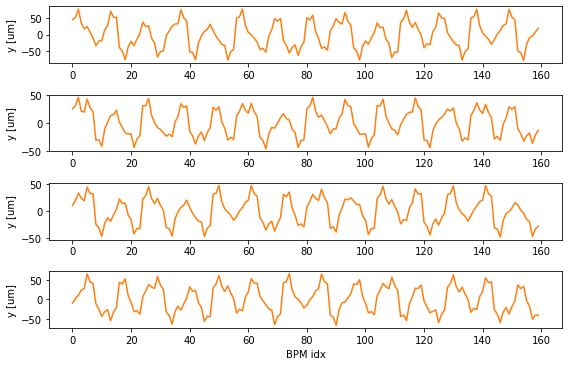

In [188]:
fig, axis = plt.subplots(4, figsize=(8, 5))
for j,ax in enumerate(axis):
    ax.plot(mat_orby[:, j]*1e6, color='tab:orange')
    ax.set_ylabel('y [um]')
plt.tight_layout()
axis[-1].set_xlabel('BPM idx')
plt.show()

In [30]:
save_pickle({'mat_orbx': mat_orbx, 'mat_orby':mat_orby}, 'fast-corrs-model-cod-signatures', True)